# Comprehensive Chorus Example: GATA1 Regulatory Analysis with Enformer and ChromBPNet

This notebook demonstrates all major features of the Chorus library using the Enformer oracle to analyze the GATA1 transcription start site (TSS) region.

GATA1 is an essential transcription factor for red blood cell development, making it an interesting target for regulatory analysis.

## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Enformer environment
chorus setup --oracle enformer

# 5. Set up the ChromBPNet environment
chorus setup --oracle chrombpnet

# 6. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

# Setup and Imports

In [1]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

Chorus version: 0.1.0


# 1. Setting Up Reference Genome and Annotations

Oracles predictions are done on the **reference genome**. Chorus downloads for you both the reference genome and annotations file if not already available on your paths.

In [2]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

2025-12-03 09:23:43,937 - chorus.utils.annotations - INFO - Annotation file already exists: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf



Setting up gene annotations...
Using annotations: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf
Setting up reference genome...
Using genome: /storage_1/lruggeri/projects/chorus/genomes/hg38.fa


# 2. Create an Oracle

**Oracles** are the main objects in Chorus. They manages models that can make predictions on the genome. Let's start by downloading [Enformer](https://www.nature.com/articles/s41592-021-01252-x), a state-of-the-art sequence-to-activity models that can predict **5.313 human genomic tracks** with a context window of 196 kbp.

In [3]:
oracle = chorus.create_oracle(
    'enformer', 
    use_environment=True,
    reference_fasta=str(genome_path)
)

# Load pre-trained model
oracle.load_pretrained_model()
print("Model loaded successfully!")

2025-12-03 09:23:46,600 - chorus.core.base - INFO - Device: auto-detect (GPU if available, else CPU)
2025-12-03 09:23:46,607 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /storage_1/lruggeri/miniforge3/bin/conda
2025-12-03 09:23:46,607 - chorus.core.environment.manager - INFO - Found mamba at: /storage_1/lruggeri/miniforge3/bin/mamba
2025-12-03 09:23:49,090 - chorus.core.base - INFO - Using conda environment: chorus-enformer
2025-12-03 09:23:49,091 - chorus.oracles.enformer - INFO - Loading Enformer model from https://tfhub.dev/deepmind/enformer/1...
2025-12-03 09:23:51,610 - chorus.oracles.enformer - INFO - Enformer model loaded successfully in environment!


Model loaded successfully!


# 2.1 Exploring Available Tracks

**Chorus** let's you navigate easily on the *tracks* supported by each model. Here we explore:
1. The available assay types
2. The available cell types
2. The number of *tracks* for each assay type

In [4]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
for i, assay in enumerate(assay_types, 1):
    print(f"  {i:2d}. {assay}")

print("\n" + "="*50 + "\n")

# List available cell types (show first 5 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
for i, cell in enumerate(cell_types[:5], 1):
    print(f"  {i:2d}. {cell}")
print(f"  ... and {len(cell_types) - 5} more")

# Get track summary
print("\n" + "="*50 + "\n")
track_summary = oracle.get_track_info()
print("Track summary by assay type:")
for assay, count in track_summary.items():
    print(f"  {assay}: {count} tracks")

2025-12-03 09:23:58,568 - chorus.oracles.enformer_source.enformer_metadata - INFO - Loaded 5313 track metadata entries


Available assay types (4):
   1. ATAC
   2. CAGE
   3. CHIP
   4. DNASE


Available cell types (1267):
   1. 3xFLAG-AHR
   2. 3xFLAG-ARID4B
   3. 3xFLAG-ATF1
   4. 3xFLAG-ATF4
   5. 3xFLAG-BCL6
  ... and 1262 more


Track summary by assay type:
  ATAC: 10 tracks
  CAGE: 638 tracks
  CHIP: 3991 tracks
  DNASE: 674 tracks


For this analysis we will focus on **K562**: a human leukemia cell line. We would like to see *chromatin accessibility* (DNase-seq) together with *gene expression* (CAGE-seq) tracks in such cells.

In [7]:
# Check our target tracks
print("K562 tracks available:")

# Search for K562 tracks
dnase_k562 = oracle.get_track_info("DNASE:K562")

print(f"\nDNASE:K562 - {len(dnase_k562)} tracks found")
if len(dnase_k562) > 0:
    print("First 3:")
    for idx, row in dnase_k562.head(3).iterrows():
        print(f"  - {row['identifier']}: {row['description']}")

# Define the specific track IDs we'll use
print("\n" + "="*50)
print("\nFor this analysis, we'll use these specific track IDs:")
track_ids = ['ENCFF413AHU'] #'ENCFF136DBS'] # the last is DNASE:HepG2
print(f"  - {track_ids[0]} (DNASE:K562)")

K562 tracks available:

DNASE:K562 - 7 tracks found
First 3:
  - ENCFF899YDP: DNASE:K562 treated with 1 uM vorinostat for 72 hours
  - ENCFF515UNC: DNASE:K562 G2 phase
  - ENCFF708UIS: DNASE:K562 G1 phase


For this analysis, we'll use these specific track IDs:
  - ENCFF413AHU (DNASE:K562)


## Example A: Wild-type Sequence Prediction

First, let's analyze the wild-type **GATA1** TSS region on *chromosome X*.

In [8]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


Now we are ready to make predictions!

## GATA1 Predictions using Chorus

Making predictions with **Chorus** is really simple! You just need to provide the *input coordinates* and the *tracks* to your oracle and Chorus will do the job.

In [9]:
# Make predictions for wild-type sequence
print("Making predictions using specific track identifiers...")
print(f"Track IDs: {track_ids}")

wt_results = oracle.predict(
    ('chrX', 48777634, 48790694),
    track_ids  # Using specific track IDs
)

Making predictions using specific track identifiers...
Track IDs: ['ENCFF413AHU']


You can also save your predictions as *bedgraph* file format. 

In [10]:
# Save tracks using oracle method - Enformer handles coordinate mapping internally
print("\nSaving wild-type tracks...")
wt_files = wt_results.save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix='a_wt'
)

print(f"Saved {len(wt_files)} files to bedgraph_outputs/")


Saving wild-type tracks...
Saved 1 files to bedgraph_outputs/


Using *coolbox* you can easily plot predictions.

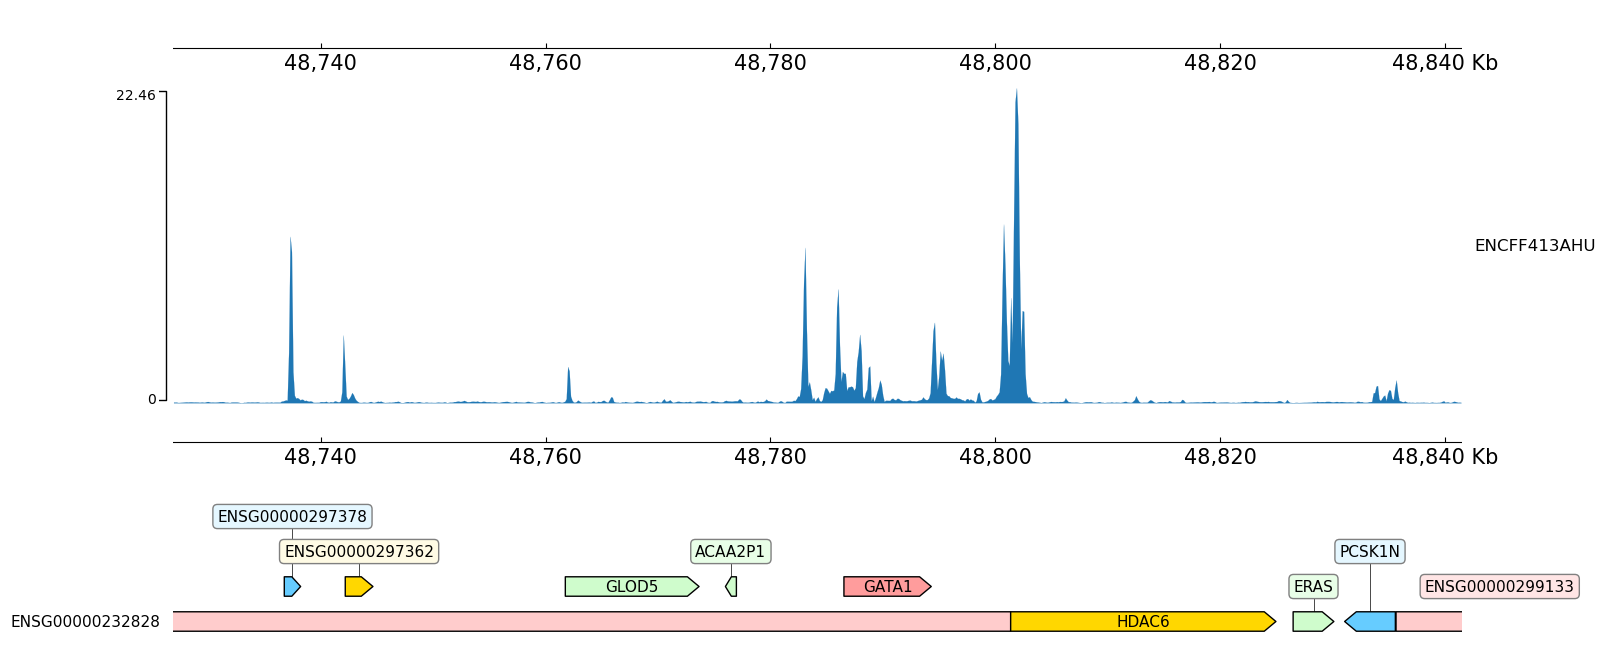

In [12]:
from coolbox.api import *

frame = (
    XAxis() 
    + wt_results[track_ids[0]].get_coolbox_representation(
        add_xaxis=True,
        add_vlines=False
    )
    + GTF(str(gtf_path)) # input annotations    
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

*Et voilà!* In just few lines of code we have both *chromatin accessibility* and *gene expression* tracks for GATA1, together with a nice visualization with annotations.

Now let's say that we want to use another model, like ChromBPNet, to compare the DNASE tracks.

## ChromBPNet Oracle

[ChromBPNet](https://pubmed.ncbi.nlm.nih.gov/39829783/) is a deep learning DNA sequence model of *base-resolution* accessibility profiles. This means that we'll only focus on **DNASE-seq** tracks here.

First we need to create the oracle

In [13]:
chrombpnet_oracle = chorus.create_oracle(
    'chrombpnet', 
    use_environment=True,
    reference_fasta=str(genome_path)
)

2025-12-03 09:25:21,345 - chorus.core.base - INFO - Device: auto-detect (GPU if available, else CPU)
2025-12-03 09:25:21,346 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /storage_1/lruggeri/miniforge3/bin/conda
2025-12-03 09:25:21,346 - chorus.core.environment.manager - INFO - Found mamba at: /storage_1/lruggeri/miniforge3/bin/mamba
2025-12-03 09:25:22,589 - chorus.core.base - INFO - Using conda environment: chorus-chrombpnet


And then we load the corresponding model

In [14]:
chrombpnet_oracle.load_pretrained_model(
    assay="DNASE",
    cell_type="K562",
)

2025-12-03 09:25:24,625 - chorus.oracles.chrombpnet - INFO - Loading ChromBPNet model...


Loading in environment


2025-12-03 09:25:26,952 - chorus.oracles.chrombpnet - INFO - ChromBPNet model loaded successfully in environment!


Now it's time to make **predictions**

In [15]:
tracks = ['DNASE:K562'] 

chrombpnet_results = chrombpnet_oracle.predict(
    ("chrX", 48_730_000, 48_840_000), # Here we need to extend to match Enformer context length
    tracks
)

# Save predictions as bedgraph
bpnet_results = chrombpnet_results.save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix="a_wt_chrombpnet"
)

And again you can plot them using *coolbox*.

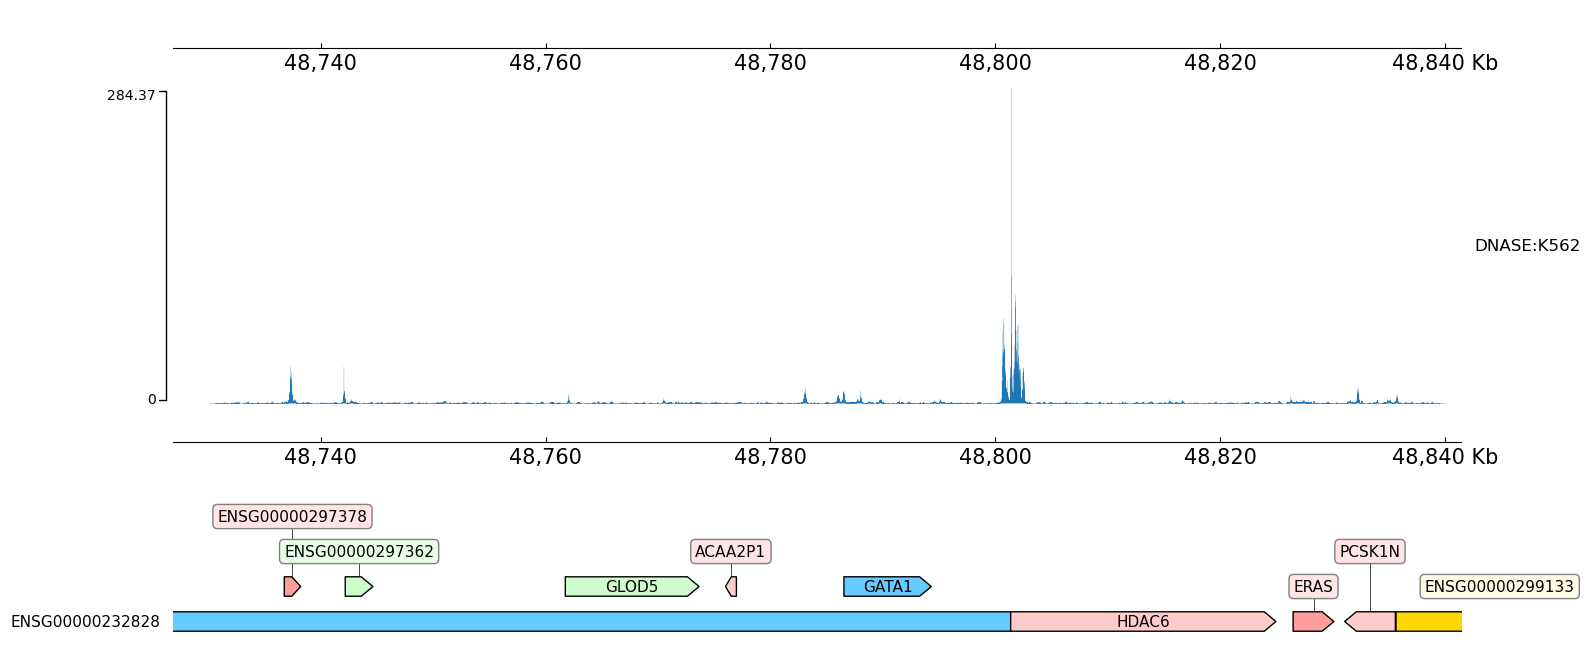

In [16]:
from coolbox.api import *

frame = (
    XAxis() 
    + chrombpnet_results[tracks[0]].get_coolbox_representation(
        add_xaxis=True,
        add_vlines=False,
        title=f"{tracks[0]}"
    )
    + GTF(str(gtf_path)) # input annotations    
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

And now you have predictions coming also from ChromBPNet!

Moreover, we can utilize **coolbox** to plot predictions side by side to better visualize differences between the two models. In this case we load predictions directly from bedgraph files.

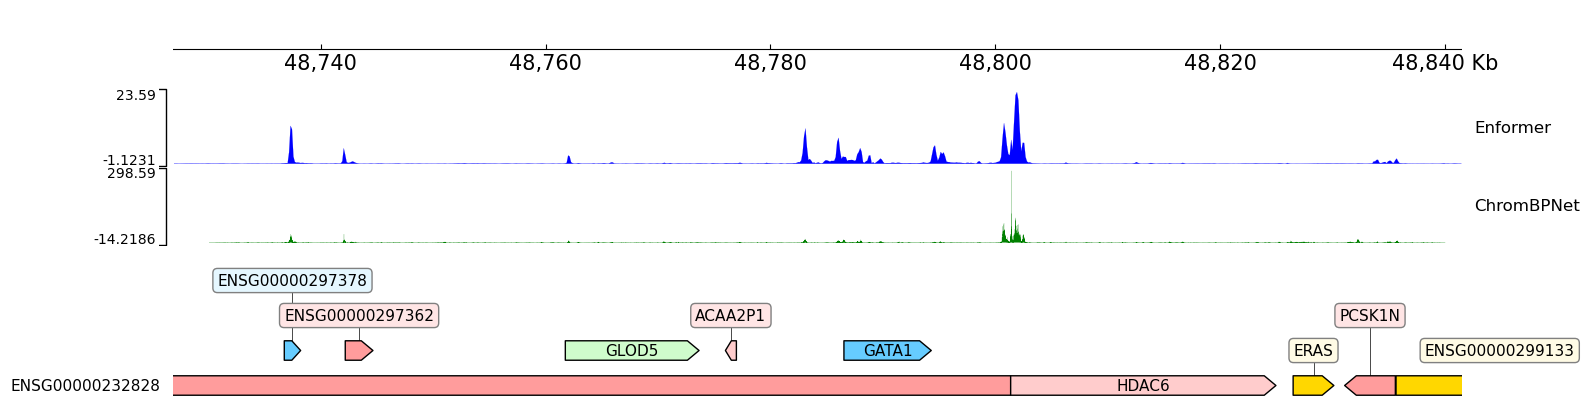

In [17]:
from coolbox.api import *

# Load enformer track
enformer_track = BedGraph(
    "./bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph",
     color="blue",
     title="Enformer"
)

# Load ChromBPNet track
chrombpnet_track = BedGraph(
    "./bedgraph_outputs/a_wt_chrombpnet_DNASE_K562.bedgraph",
    color="green",
    title="ChromBPNet"
)

frame = (
    XAxis() 
    + enformer_track 
    + chrombpnet_track
    + GTF(str(gtf_path)) # input annotations
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

## Example B: Region Replacement

Now let's say that we want to measure the effect of a sequence injected in our interval.

In [18]:
# Define replacement parameters
replace_region = "chrX:48782929-48783129"
replacement_seq = "CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCAAAGGCGACACCCAACATGTGCGTGCTTGAGATAATGACTAAAAACTGCCCGTGACTCAAGCGCTTCTGGTGAGGGAAGATAAGGCAAGGAAACTGGCCGCCTAGATAGCCCTGGGAATGAGGCAGTCTCTGTTCTGGGTAAAGTGTCTGC"

print(f"Replacing region: {replace_region}")
print(f"Original region length: 200 bp")
print(f"Replacement sequence length: {len(replacement_seq)} bp")
print(f"\nReplacement sequence (first 50 bp): {replacement_seq[:50]}...")

Replacing region: chrX:48782929-48783129
Original region length: 200 bp
Replacement sequence length: 200 bp

Replacement sequence (first 50 bp): CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCA...


You can predict the effect of the region replacement just by using `predict_region_replacement` method on your **oracle**.

In [19]:
# Make predictions with replacement
print("Making predictions with replaced region...\n")
replacement_results = oracle.predict_region_replacement(
    genomic_region=replace_region,
    seq=replacement_seq,
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)

# Save predictions to bedgraph file
replacement_files = replacement_results["raw_predictions"].save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix="replacement_enformer"
)

Making predictions with replaced region...



Now analyze the changes.

In [20]:
# Analyze changes
print("Signal changes due to replacement:")
for track_id in track_ids:
    predictions = replacement_results['normalized_scores'][track_id]
    print(f"\n{track_id}:")
    print(f"  Mean signal: {np.mean(predictions.values):.4f}")
    print(f"  Max signal: {np.max(predictions.values):.4f}")

Signal changes due to replacement:

ENCFF413AHU:
  Mean signal: 0.0234
  Max signal: 1.0000


Let's visualize predictions with replacement for both tracks using *coolbox*.

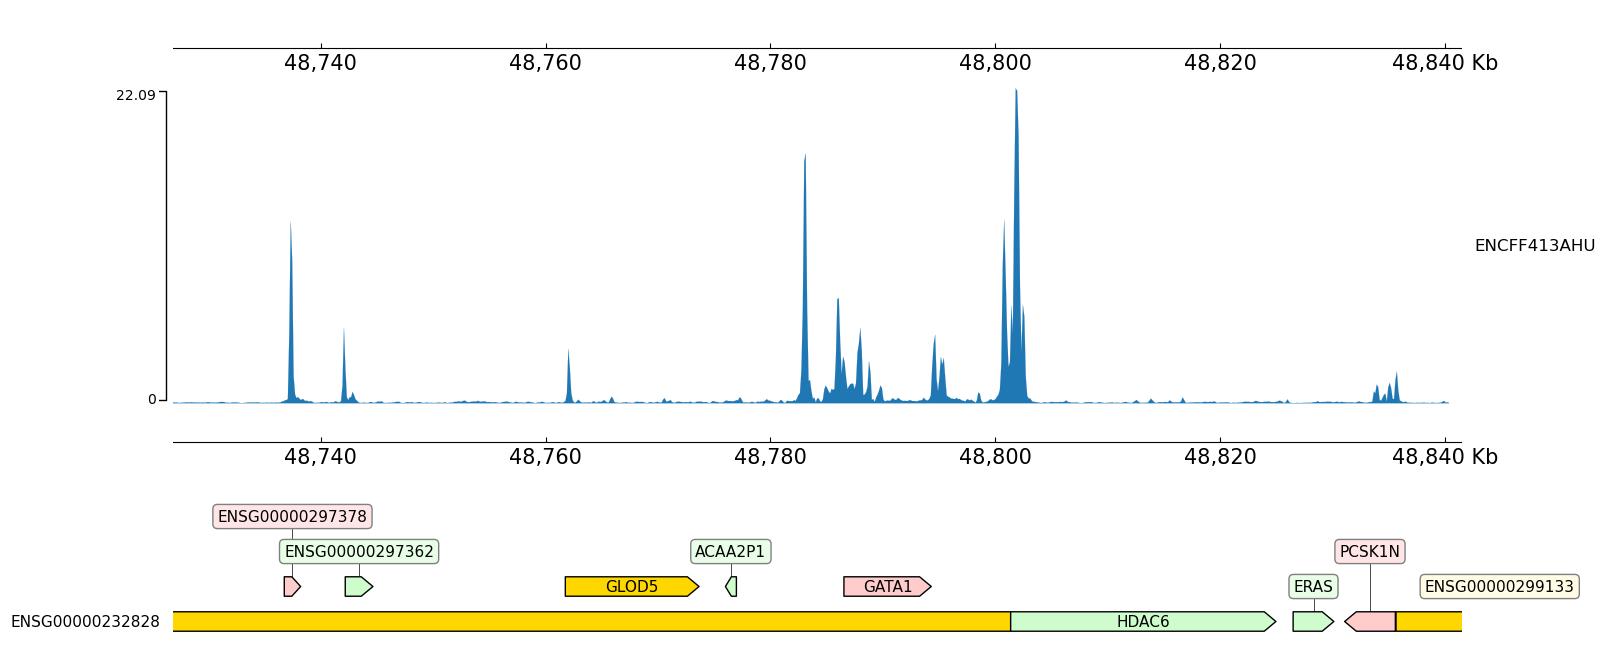

In [22]:
from coolbox.api import *

frame = (
    XAxis() 
    + replacement_results["raw_predictions"][track_ids[0]].get_coolbox_representation(
        add_xaxis=True,
        add_vlines=False,
    )
    + GTF(str(gtf_path)) # input annotations    
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

And again, you can replicate the analysis with ChromBPNet (using only the DNASE-seq track). Here since ChromBPNet has a narrower context window, we manually inject the sequence in the desired interval and collect predictions.

In [23]:
from chorus.core.interval import Interval, GenomeRef

chrombpnet_tracks = ["DNASE:K562"]

replace_region = (48782929, 48783129)
replace_region_length = replace_region[1] - replace_region[0]

interval = Interval.make(GenomeRef(chrom="chrX", start=48_730_000, end=48_840_000, fasta=str(genome_path)))
region_interval = interval.replace(
    seq=replacement_seq,
    start=replace_region[0] - interval.reference.start,
    end=replace_region[0] - interval.reference.start + replace_region_length
)

# Get predictions for the full context
predictions = chrombpnet_oracle.predict(
    region_interval, 
    chrombpnet_tracks
)

# Save predictions as bedgraph
chrombpnet_files = predictions.save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix="replacement_chrombpnet"
)

And visualize them with *coolbox*.

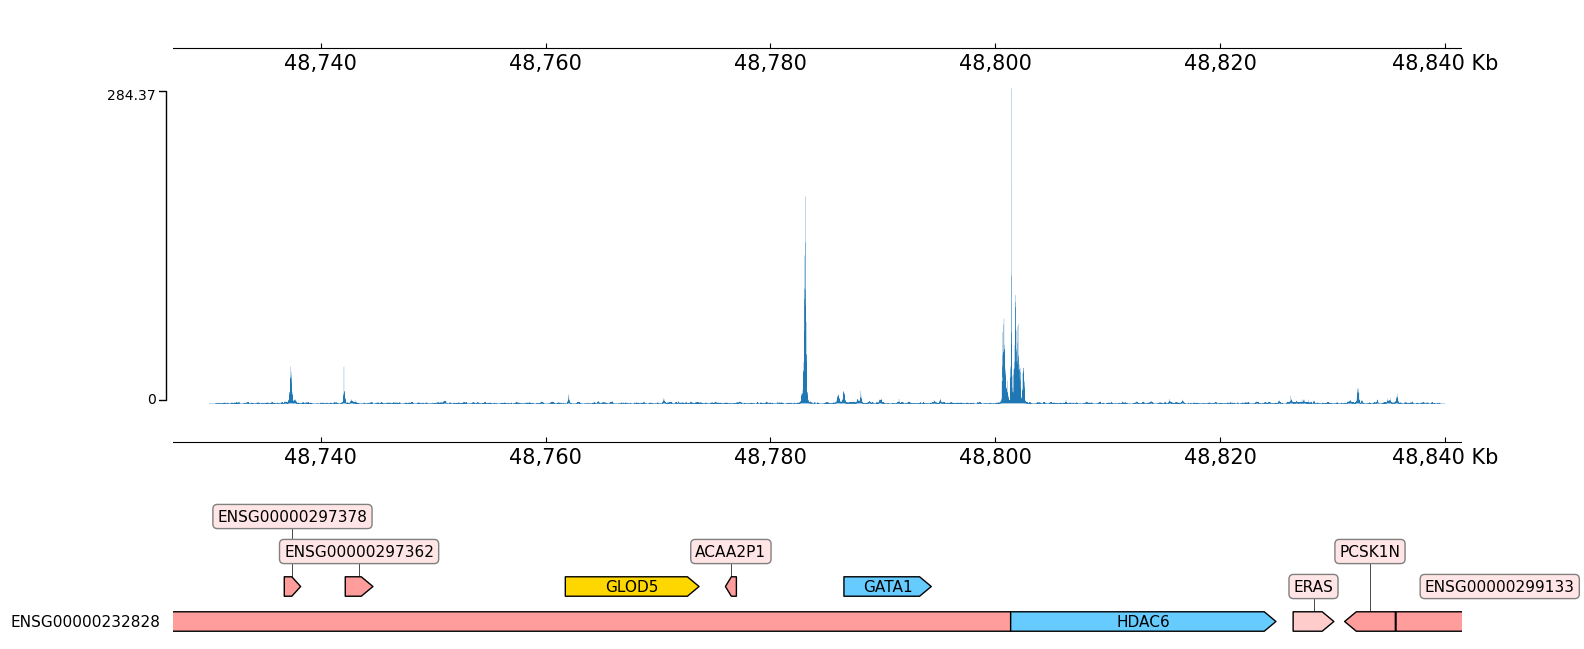

In [24]:
from coolbox.api import *

frame = (
    XAxis() 
    + predictions[chrombpnet_tracks[0]].get_coolbox_representation(
        add_xaxis=True,
        add_vlines=False,
    )
    + GTF(str(gtf_path)) # input annotations    
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

And again you can use **coolbox** to visualize all tracks together with the replacement effect in just *few* lines of code.

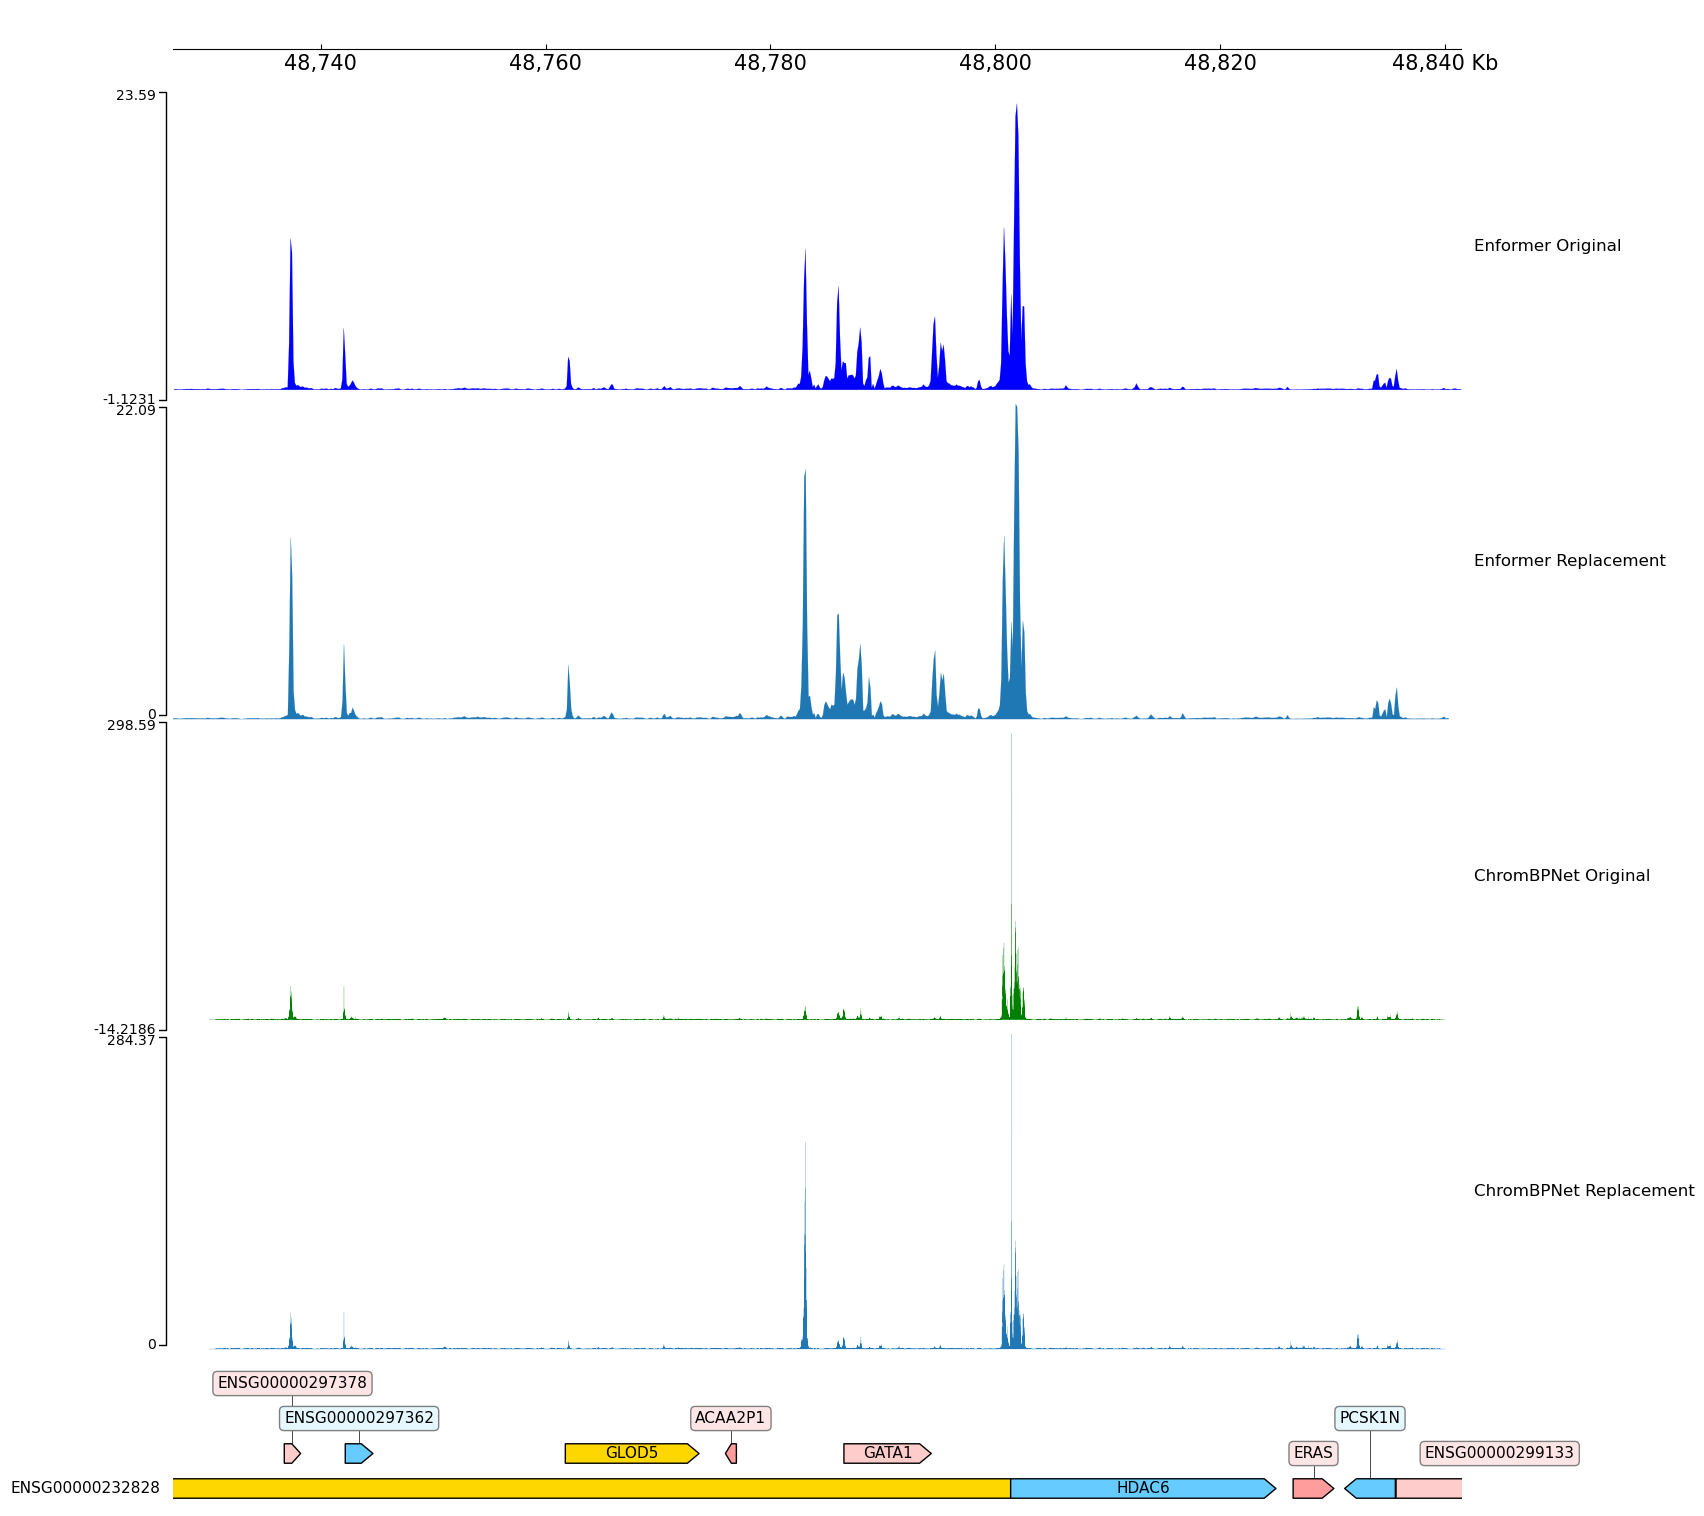

In [25]:
from coolbox.api import *

# Load enformer tracks from bedgraph file
enformer_track = BedGraph(
    "./bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph",
     color="blue",
     title="Enformer Original"
)

# Load ChromBPNet tracks from bedgraph file
chrombpnet_track = BedGraph(
    "./bedgraph_outputs/a_wt_chrombpnet_DNASE_K562.bedgraph",
    color="green",
    title="ChromBPNet Original"
)

frame = (
    XAxis() 
    + enformer_track 
    + TrackHeight(8)
    + replacement_results["raw_predictions"][track_ids[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="Enformer Replacement"
    )
    + chrombpnet_track
    + TrackHeight(8)
    + predictions[chrombpnet_tracks[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="ChromBPNet Replacement"
    )
    + GTF(str(gtf_path)) # input annotations    
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

You can clearly see from here that **ChromBPNet** is much more sensible to the inserted sequence.

# Example C: Variant Effect Analysis

Explore the effect of variants injected in specific positions.

For this specific example, we will use **CTCF**, a well-known transciptional factor involved in transcriptional regulation with insulator activity. **CTCF** binds to short, regulatory patterns called *motifs*.

<style>
    figcaption {
        font-style: italic;
    }
</style>
<figure>
<img src="images/MA0139.1.svg">
<figcaption align="center"> CTCF Motif </figcaption>
</figure>

TFs bind to open chromatin regions, which can be seen from DNase-seq tracks. For this example, we will use the binding site on *SH3YL1* gene, in chromosome 2.

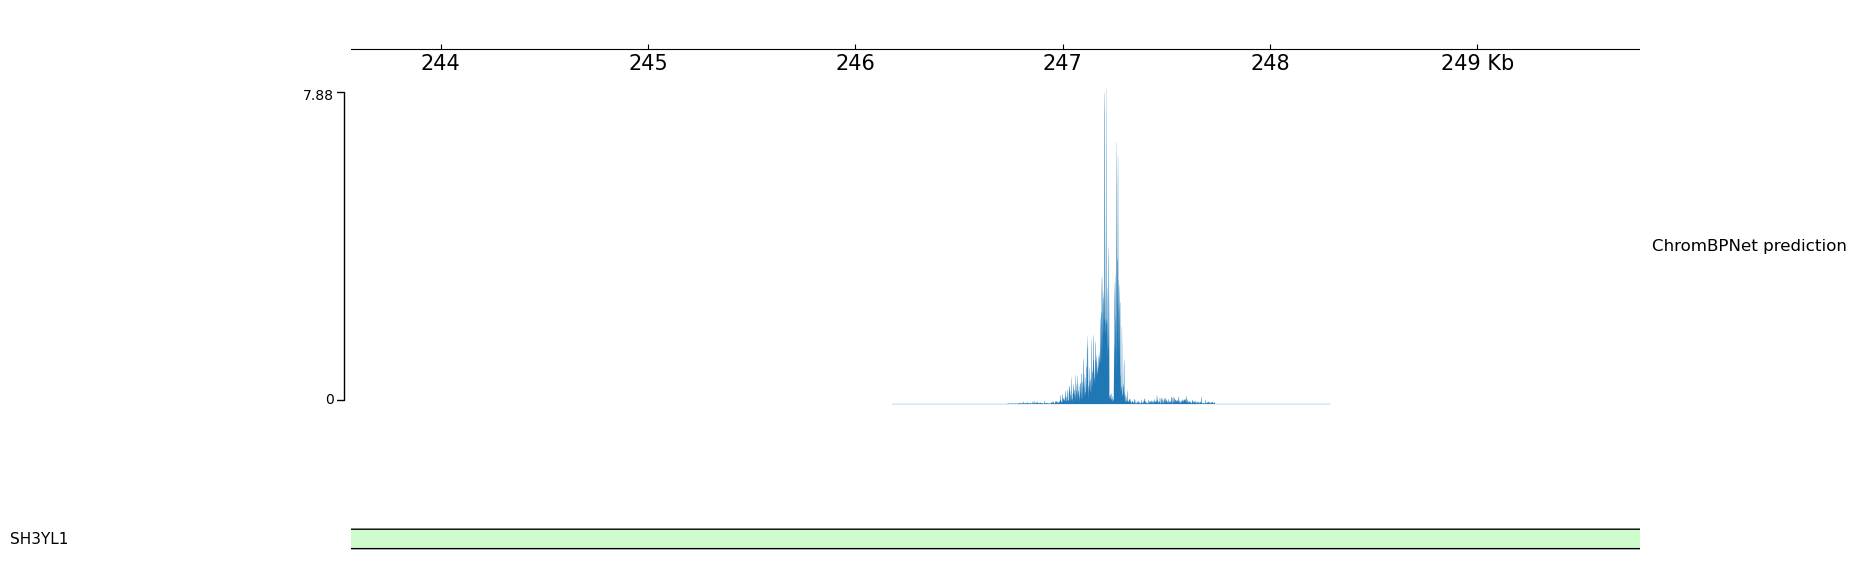

In [27]:
from coolbox.api import *

ctcf_interval = Interval.make(GenomeRef(chrom="chr2", start=246_567, end=246_783, fasta=str(genome_path)))

ctcf_predictions = chrombpnet_oracle.predict(
    ctcf_interval,
    chrombpnet_tracks
)

frame = (
    XAxis()
    + ctcf_predictions[chrombpnet_tracks[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="ChromBPNet prediction"
    )
    + GTF(str(gtf_path))
)

frame.plot("chr2:243567-249783")

Now we want to see what happens when we disrupt the motif. In this example, we will **mutate** the first *G* in the motif and see what happens to the predictions.

**Chorus** allows you to do it in a simple way using `predict_variant_effect` on the **oracle**.

In [28]:
# We now that the motif starts in position 105 "CCAGAGGGC" we want to mutate the first G
first_G_position_in_int = 108
variant_pos = first_G_position_in_int + ctcf_interval.reference.start
ref_seq = "G"

# Create alleles list with reference first, then alternatives
alt_alleles = [a for a in ['A', 'C', 'G', 'T'] if a != ref_seq]
test_alleles = [ref_seq] + alt_alleles  # Reference first, then alternatives

print("\nPredicting variant effects...\n")
variant_results = chrombpnet_oracle.predict_variant_effect(
    genomic_region=f"chr2:{variant_pos-1000}-{variant_pos+1000}",
    variant_position=f"chr2:{variant_pos}",
    alleles=test_alleles,  # Reference first, then alternatives
    assay_ids=chrombpnet_tracks,  # Using specific track IDs
    genome=str(genome_path)
)

print("\nVariant predictions completed!")


Predicting variant effects...


Variant predictions completed!


Once we have the predictions for all alternative nucleotides, we can show their effects.

In [32]:
# Create a report for the variant effects
# Analyze variant effects
print("Variant effect analysis:")
print("=" * 60)

# Create results dataframe
variant_effects = []

# Get reference predictions - it's a dictionary, not a 2D array
ref_predictions = variant_results['predictions']['reference']

for track_id in chrombpnet_tracks:
    # Get reference signal for this track
    ref_signal = np.mean(ref_predictions[track_id].values)
    
    # Add reference to dataframe
    variant_effects.append({
        'Track': track_id,
        'Allele': ref_seq,
        'Signal': ref_signal,
        'Effect': 0.0,
        'Is_Reference': True
    })
    
    # Add alternatives
    for i, allele in enumerate(alt_alleles):
        allele_key = f'alt_{i+1}'
        if allele_key in variant_results['predictions']:
            alt_predictions = variant_results['predictions'][allele_key]
            alt_signal = np.mean(alt_predictions[track_id].values)
            effect = alt_signal - ref_signal
            
            variant_effects.append({
                'Track': track_id,
                'Allele': allele,
                'Signal': alt_signal,
                'Effect': effect,
                'Is_Reference': False
            })

# Create DataFrame for easier analysis
variant_df = pd.DataFrame(variant_effects)
variant_df

Variant effect analysis:


,Track,Allele,Signal,Effect,Is_Reference
0,DNASE:K562,G,0.153172,0.000000,True
1,DNASE:K562,A,0.064638,-0.088534,False
2,DNASE:K562,C,0.060803,-0.092369,False
3,DNASE:K562,T,0.059285,-0.093887,False


And you can easily visualize the differences using *coolbox*

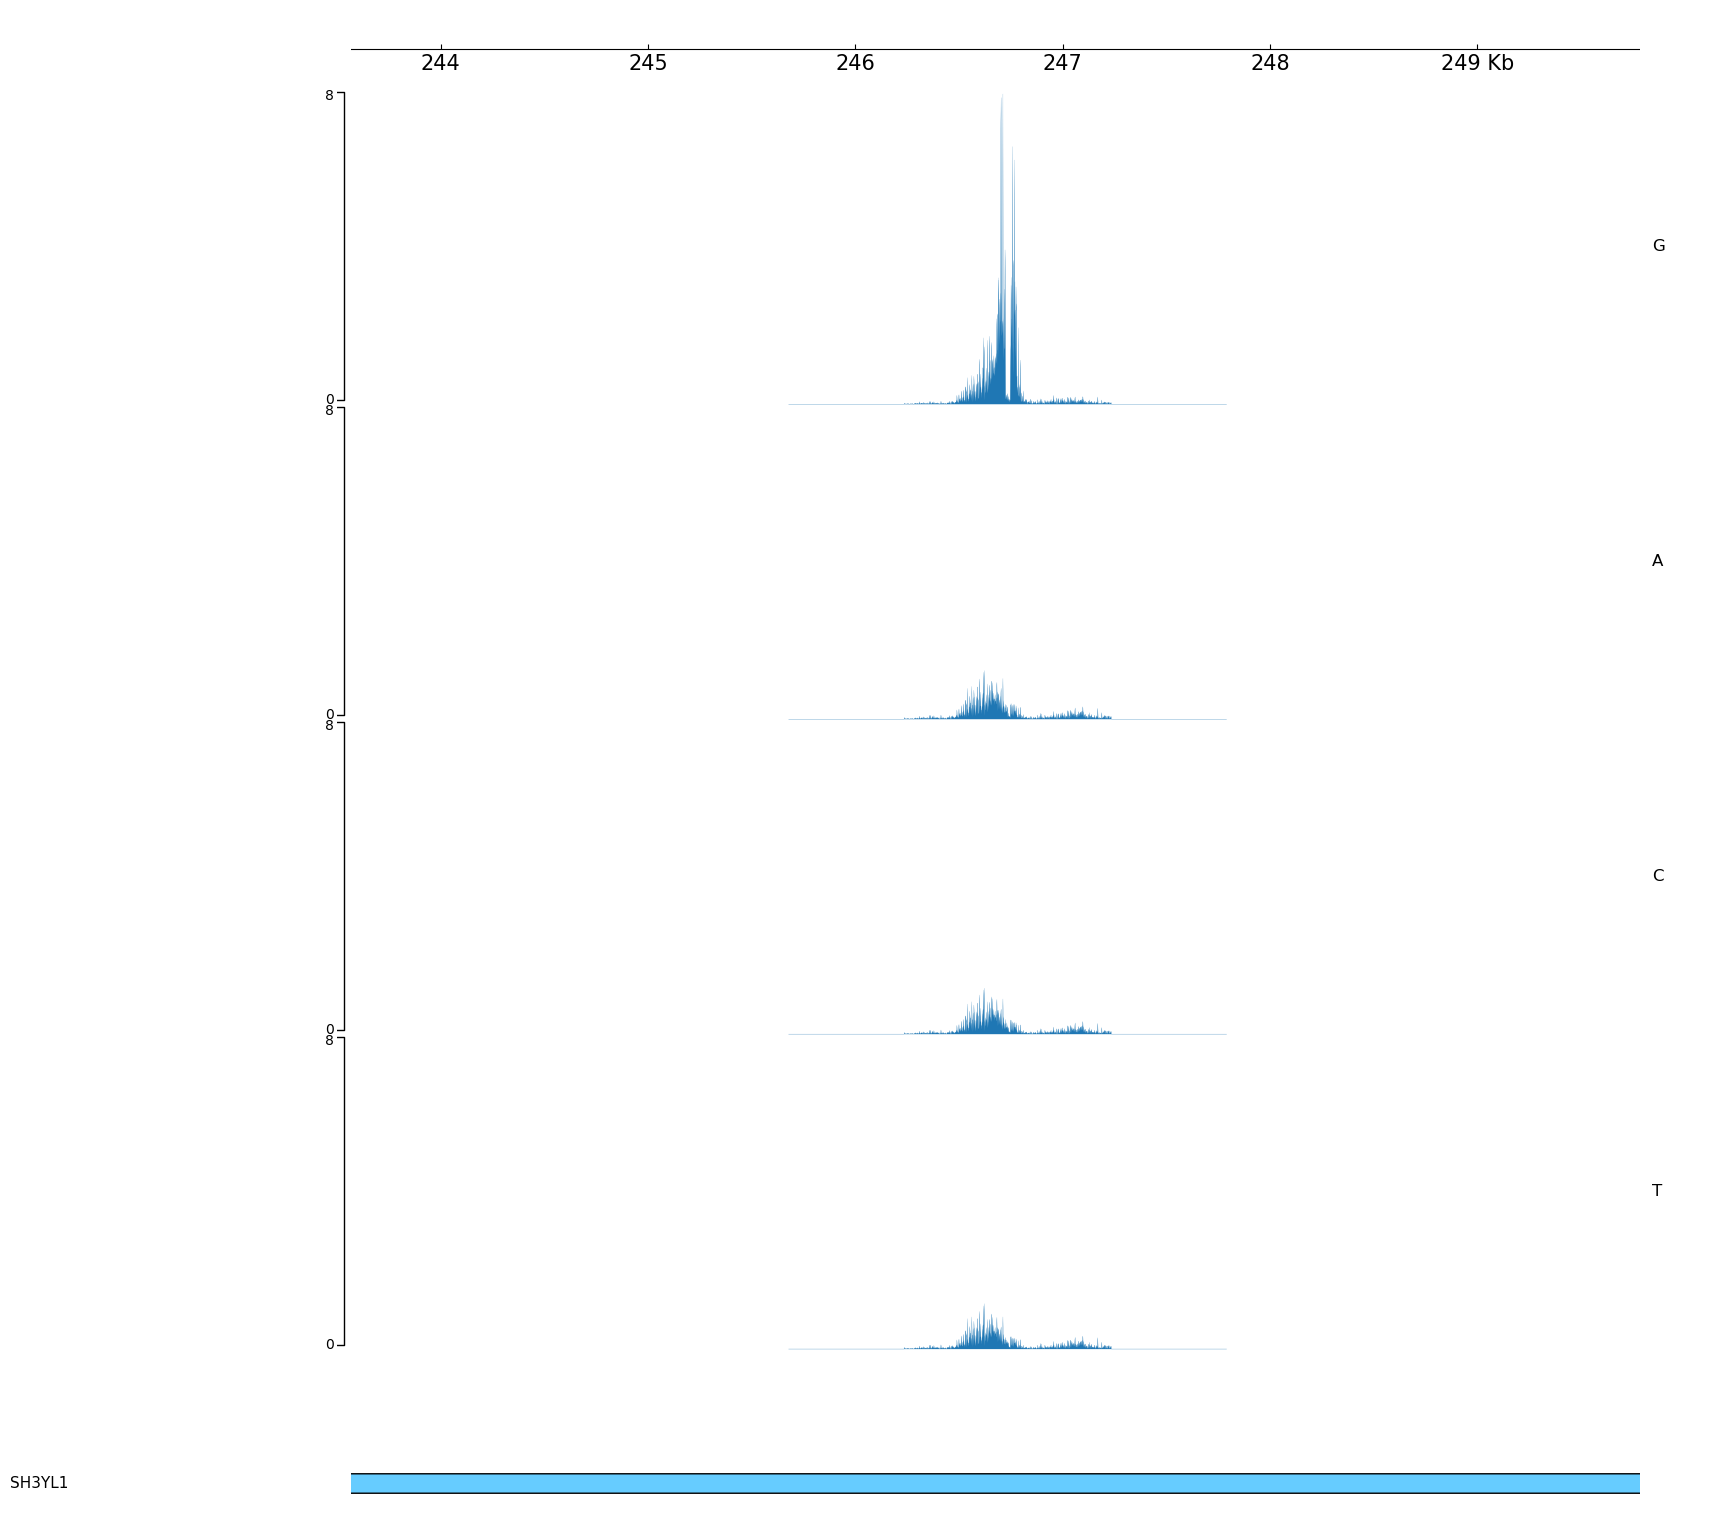

In [57]:
from coolbox.api import *

variant_predictions = variant_results['predictions']

tracks = [
    variant_predictions[k][chrombpnet_tracks[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title=f"{test_alleles[i]}"
    ) + MaxValue(8) # Necessary to see the differences
    for i, k in enumerate(variant_predictions.keys())
]

frame = XAxis()
frame = sum(tracks, frame)
frame = frame + (GTF(str(gtf_path)))

frame.plot("chr2:243567-249783")

From here you can clearly see how that *G* was defining the *motif* and mutating it causes the chromatin to **close**. 

# Example D: Change Cell Type

Until now we've focused on K562 Cell Type, but let's say that we want to shift our GATA1 Analysis on HepG2 cell type.

**Enformer** and **ChromBPNet** have two different architectures:
- **Enformer** has a single backbone and *multiple* heads (one for each track), so we just need to *change* the track ID to get DNASE-seq HepG2 tracks.
- **ChromBPNet** models are trained *separately* on different cell types and tracks, so we need to load the correct model for making predictions on HepG2 cell line.

So the Enformer setup is just one line of code...

In [58]:
# Enformer Setup: Just change the head ID
track_ids = ['ENCFF136DBS'] # DNASE:HepG2

For ChromBPNet we need to load the DNASE:HepG2 model.

In [59]:
chrombpnet_oracle.load_pretrained_model(
    assay="DNASE",
    cell_type="HepG2",
)

2025-12-03 10:10:34,271 - chorus.oracles.chrombpnet - INFO - Dowloading ChromBPNet into /storage_1/lruggeri/projects/chorus/downloads/chrombpnet/DNASE_HepG2...
2025-12-03 10:12:35,671 - chorus.oracles.chrombpnet - INFO - Dowload completed!
2025-12-03 10:12:38,903 - chorus.oracles.chrombpnet - INFO - Loading ChromBPNet model...


Loading in environment


2025-12-03 10:12:41,190 - chorus.oracles.chrombpnet - INFO - ChromBPNet model loaded successfully in environment!


And now we are ready to reproduce any analysis, but on **HepG2** now. Let's start on making predictions using **Enformer** on the same GATA1 region from *Example A*.

In [60]:
enformer_HepG2 = oracle.predict(
    ('chrX', 48777634, 48790694),
    track_ids  # Using specific track IDs
)

Now let's make predictions using **ChromBPNet**...

In [68]:
chrombpnet_tracks = ["DNASE:HepG2"]

chrombpnet_HepG2 = chrombpnet_oracle.predict(
    ('chrX', 48_730_000, 48_840_000),  # needed to match Enformer context length
    chrombpnet_tracks
)

And we can compare these predictions with the one coming from **K562** to see their differences.

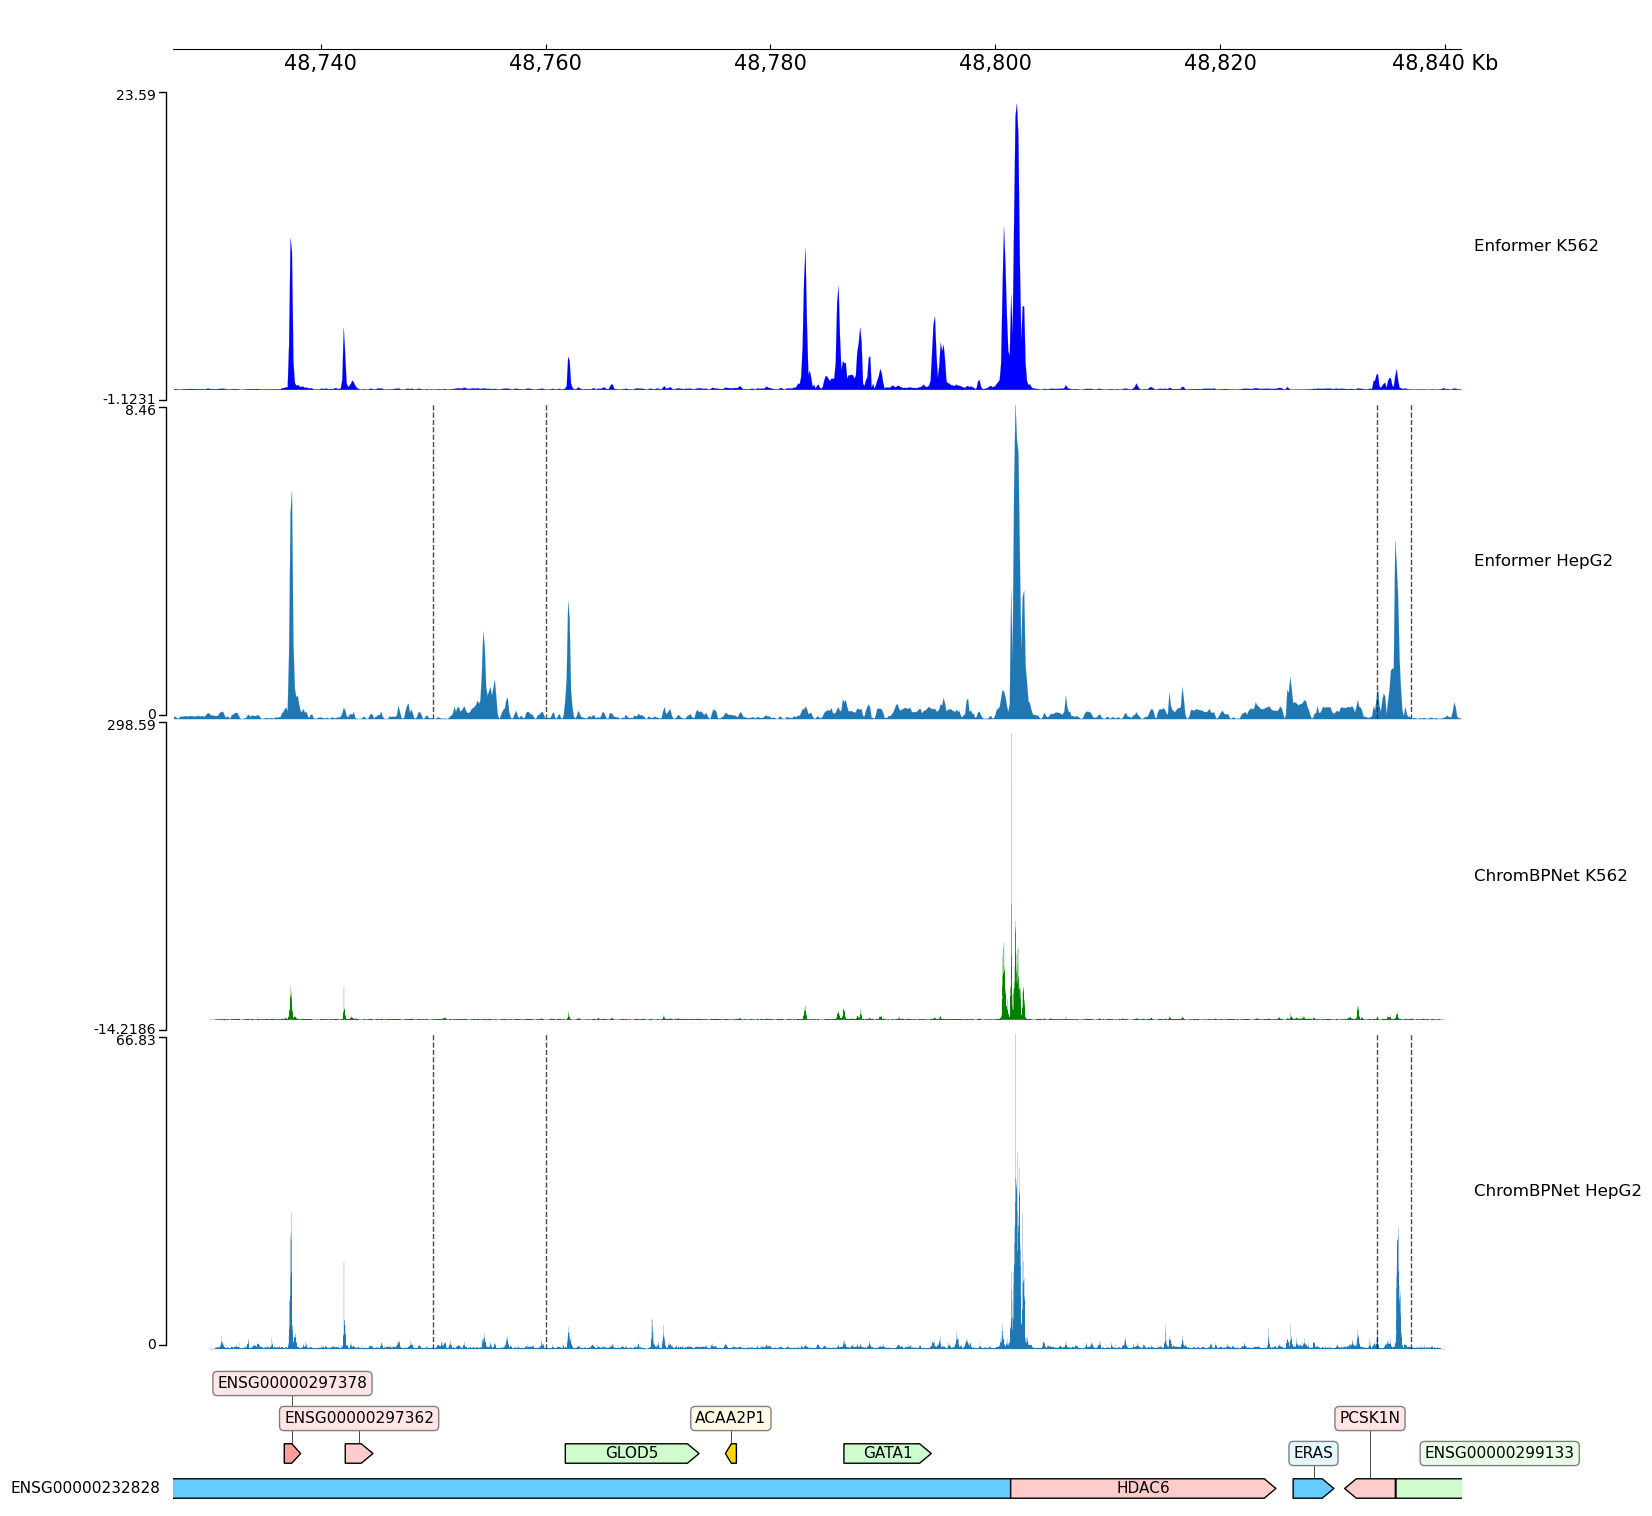

In [79]:
from coolbox.api import *

# Load Enformer K562 predictions from bedgraph
enformer_K562 = BedGraph(
    "./bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph",
     color="blue",
     title="Enformer K562"
)

# Load ChromBPNet K562 predictions from bedgraph file
chrombpnet_K562 = BedGraph(
    "./bedgraph_outputs/a_wt_chrombpnet_DNASE_K562.bedgraph",
    color="green",
    title="ChromBPNet K562"
)

frame = (
    XAxis()
    + enformer_K562 + TrackHeight(8)
    + enformer_HepG2[track_ids[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="Enformer HepG2"
    ) + Vlines(["chrX:48750000-48760000", "chrX:48834000-48837000"]) # Higlithing the difference
    + chrombpnet_K562 + TrackHeight(8)
    + chrombpnet_HepG2[chrombpnet_tracks[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="ChromBPNet HepG2"
    ) + Vlines(["chrX:48750000-48760000", "chrX:48834000-48837000"]) # Higlithing the difference
    + GTF(str(gtf_path))
)

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

And as you can see both **Enformer** and **ChromBPNet** shows differences in the highlighted regions, since we are making predictions for two different cell types.

## Summary

In this comprehensive example, we demonstrated all major features of Chorus:

1. **Wild-type prediction**: Analyzed the GATA1 TSS region
2. **Region replacement**: Replaced a 200bp region with synthetic sequence
3. **Variant analysis**: Tested all possible SNPs at a position
4. **Cell Type Analysis**: Analyzed how peaks change in different cell types.

All predictions can be made using different **oracles** and can be saved as BedGraph files that can be loaded into genome browsers for visualization.